In [13]:
from sklearn import metrics
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from dataCentric_functions import *

import medmnist
from medmnist import INFO, Evaluator

In [14]:
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG, Adam, SGD
from libauc.models import resnet20 as ResNet20
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score
from libauc.models import resnet18 as ResNet18

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score
#from pytorchtools import EarlyStopping
import sys

In [15]:
import matplotlib.pyplot as plt

In [16]:
import os

# make directory for adrenal
if not os.path.exists('vessel'):
    os.makedirs('vessel')

In [17]:
data_flag = 'vesselmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [18]:
# preprocessing

data_transform1 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [19]:
train_dataset1 = DataClass(split='train', transform=data_transform1, download=download)
val_dataset1 = DataClass(split='val', transform=data_transform1, download=download)
test_dataset = DataClass(split='test', transform=data_transform1, download=download)

train_dataset1

Using downloaded and verified file: C:\Users\gunja\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\gunja\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\gunja\.medmnist\vesselmnist3d.npz


Dataset VesselMNIST3D (vesselmnist3d)
    Number of datapoints: 1335
    Root location: C:\Users\gunja\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'vessel', '1': 'aneurysm'}
    Number of samples: {'train': 1335, 'val': 192, 'test': 382}
    Description: The VesselMNIST3D is based on an open-access 3D intracranial aneurysm dataset, IntrA, containing 103 3D models (meshes) of entire brain vessels collected by reconstructing MRA images. 1,694 healthy vessel segments and 215 aneurysm segments are generated automatically from the complete models. We fix the non-watertight mesh with PyMeshFix and voxelize the watertight mesh with trimesh into 28×28×28 voxels. We split the source dataset with a ratio of 7:1:2 into training, validation and test set.
    License: CC BY 4.0

In [20]:
train_counts = np.unique(train_dataset1.labels, return_counts=True)
val_counts = np.unique(val_dataset1.labels, return_counts=True)
print(f"class ratio: {train_counts}")
print(f"class ratio: {val_counts}")
print(f"class ratio: {np.unique(test_dataset.labels, return_counts=True)}")
train_val_comb = train_counts[1] + val_counts[1]
neg_counts, pos_counts = train_val_comb[0], train_val_comb[1]
print(f"train+validation class ratio: {neg_counts, pos_counts}")

class ratio: (array([0, 1], dtype=uint8), array([1185,  150], dtype=int64))
class ratio: (array([0, 1], dtype=uint8), array([170,  22], dtype=int64))
class ratio: (array([0, 1], dtype=uint8), array([339,  43], dtype=int64))
train+validation class ratio: (1355, 172)


As we see from the number of counts of each class in the dataset, this dataset is imbalanced, and we are going to balance it by upsampling technique.

Step 1: Data shifting (balance data if imblance by upsampling)

In [21]:
ct_tensors_img = torch.cat([torch.from_numpy(train_dataset1.imgs), torch.from_numpy(val_dataset1.imgs)])
ct_tensors_labels = torch.cat([torch.from_numpy(train_dataset1.labels), torch.from_numpy(val_dataset1.labels)])
ct_tensors_img.shape

torch.Size([1527, 28, 28, 28])

In [22]:
X = ct_tensors_img.float()
y = ct_tensors_labels

# splitting train and validation data with balanced ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
len(X_train)

train_d = torch.utils.data.TensorDataset(X_train, y_train)
val_d = torch.utils.data.TensorDataset(X_val, y_val)

trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE, shuffle=True)
valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [23]:
# model without balancing the dataset for comparison
# resnet18 model
from libauc.models import resnet18 as ResNet18

#writer = SummaryWriter("runs/breast")
model_imblance = ResNet18(pretrained=False, last_activation=None, num_classes=1)
model_imblance.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)


# HyperParameters
SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 50
decay_epochs = [50, 75]

lr = 0.1
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001


# loss and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model_imblance, 
                 loss_fn=loss_fn,
                 lr=lr, 
                 momentum=0.9,
                 #margin=margin)
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

#writer.add_graph(model=model)  # graph of model structure
#writer.close()
#sys.exit()



In [24]:
# early stopping patience; how long to wait after last time validation loss improved.
patience=12
train_log, val_log = train(model_imblance, loss_fn, optimizer, total_epochs, trainloader, trainloader_eval, 
                           valloader, patience=patience, decay_epochs=decay_epochs)

Start Training
------------------------------
epoch: 0, train_loss: 0.0769, train_auc: 0.4733, val_auc: 0.3709, lr: 0.1000
0
epoch: 1, train_loss: 0.0708, train_auc: 0.8731, val_auc: 0.7735, lr: 0.1000
0
epoch: 2, train_loss: 0.0441, train_auc: 0.8837, val_auc: 0.7866, lr: 0.1000
0
epoch: 3, train_loss: 0.0190, train_auc: 0.9615, val_auc: 0.8226, lr: 0.1000
0
epoch: 4, train_loss: 0.0042, train_auc: 0.9931, val_auc: 0.9053, lr: 0.1000
0
epoch: 5, train_loss: -0.0057, train_auc: 0.9942, val_auc: 0.8884, lr: 0.1000
1
epoch: 6, train_loss: -0.0055, train_auc: 0.9965, val_auc: 0.9105, lr: 0.1000
0
epoch: 7, train_loss: -0.0044, train_auc: 0.9987, val_auc: 0.9134, lr: 0.1000
1
epoch: 8, train_loss: -0.0029, train_auc: 0.9998, val_auc: 0.9139, lr: 0.1000
2
epoch: 9, train_loss: -0.0018, train_auc: 1.0000, val_auc: 0.9135, lr: 0.1000
3
epoch: 10, train_loss: -0.0012, train_auc: 1.0000, val_auc: 0.9129, lr: 0.1000
4
epoch: 11, train_loss: -0.0007, train_auc: 1.0000, val_auc: 0.9142, lr: 0.1000

Text(0.5, 0, 'Epoch')

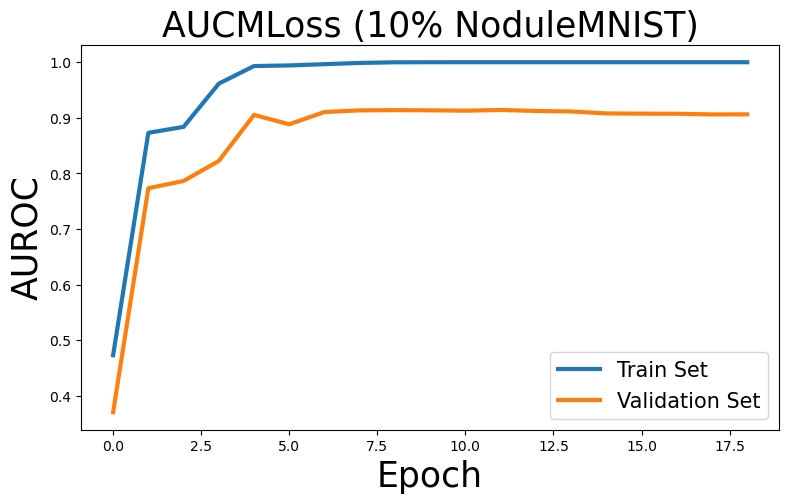

In [25]:
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, linestyle='-', label='Train Set', linewidth=3)
plt.plot(x, val_log,  linestyle='-', label='Validation Set', linewidth=3)
plt.title('AUCMLoss (10% NoduleMNIST)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)

In [28]:
X_test = torch.from_numpy(test_dataset.imgs)
X_test = X_test.float()
test_d = torch.utils.data.TensorDataset(X_test, torch.from_numpy(test_dataset.labels))

test_loader = data.DataLoader(dataset=test_d, batch_size=BATCH_SIZE)

# Testing AUC
score_list = list()
label_list = list()
for _, d in enumerate(test_loader, 0):
    tmp_data, tmp_label = d
    #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()
    
    tmp_score = model_imblance(tmp_data).detach().clone().cpu()
    score_list.append(tmp_score)
    label_list.append(tmp_label.cpu())

test_label = torch.cat(label_list)
test_score = torch.cat(score_list)
                   
test_auc = metrics.roc_auc_score(test_label, test_score)                   
print("Test : %.4f"%test_auc, flush=True)

Test : 0.7757


In [29]:
# save the model4
torch.save(model_imblance.state_dict(), "vessel/vessel_imbalance.pth")

Step 2: data augmentation

In [30]:
# We will overcome the data imbalance issue by upsamling the minority class using data augmentation
# since the majority class is almost eight times as many as the minority class, 
# seven data augmentation techniques will be employed to increase the number of images in the minority class

# HorizontalFlip
data_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=1.0)
])
# Gaussian Noise
data_transform3 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.2)
])
# Normalize
data_transform4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
# Elastic Transforms
data_transform5 = transforms.Compose([
    transforms.ToTensor(),
    transforms.ElasticTransform()
])
# Inverse Transforms
data_transform6 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomInvert(p=1)
])
# Gray Scale
data_transform7 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale()
])
# Color Jitter
data_transform8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter()
])

In [32]:
# Data upsampling function
def create_new_img_by_augmentations(desired_class, data_transform):
    # load more training and validation dataset to create new data using data augmentation
    # param: desired_class(list) is a list of classes to be kept,
    # and all the other classes not in this list will be filtered out
    # param: data_transform(pytorch.transforms) is a data transform method to be applied to dataset
    # return: pytorch dataset
    train_dataset = DataClass(split='train', transform=data_transform)
    val_dataset = DataClass(split='val', transform=data_transform)
    '''
    filtered_trainset = torch.utils.data.Subset(train_dataset,
                            [i for i in range(len(train_dataset)) if train_dataset.labels[i] in desired_class])
    filtered_valset = torch.utils.data.Subset(val_dataset,
                            [i for i in range(len(val_dataset)) if val_dataset.labels[i] in desired_class])
    '''
    
    combined_imgs = torch.cat([torch.from_numpy(train_dataset.imgs), torch.from_numpy(val_dataset.imgs)])
    combined_labels = torch.cat([torch.from_numpy(train_dataset.labels), torch.from_numpy(val_dataset.labels)])
    
    desired_class_idx = [i for i in range(len(combined_labels)) if combined_labels[i] in desired_class]
    
    #print(combined_imgs.shape)
    #print(combined_labels.shape)
    combined_imgs = combined_imgs[desired_class_idx, :, :, :]
    combined_labels = combined_labels[desired_class_idx]
    
    #return combined_imgs, combined_labels
    
    combined_train = torch.utils.data.TensorDataset(combined_imgs, combined_labels)
    
    #combined_train = torch.utils.data.ConcatDataset([filtered_trainset, filtered_valset])
    return combined_train

In [34]:
desired_class = [1]
new_combined_train = torch.utils.data.ConcatDataset([
    create_new_img_by_augmentations(desired_class, data_transform=data_transform2),
    create_new_img_by_augmentations(desired_class, data_transform=data_transform3),
    create_new_img_by_augmentations(desired_class, data_transform=data_transform4),
    create_new_img_by_augmentations(desired_class, data_transform=data_transform5),
    create_new_img_by_augmentations(desired_class, data_transform=data_transform6),
    create_new_img_by_augmentations(desired_class, data_transform=data_transform7),
    create_new_img_by_augmentations(desired_class, data_transform=data_transform8),
])
len(new_combined_train)

1204

In [37]:
from math import ceil

count_diff = int(max(neg_counts, pos_counts) - min(neg_counts, pos_counts))
random_sampler = data.RandomSampler(new_combined_train, num_samples=count_diff)
added_dataloader = data.DataLoader(new_combined_train, batch_size=BATCH_SIZE, sampler=random_sampler)

added_diter = iter(added_dataloader)
examples, labels = next(added_diter)
added_tensors_img, added_tensors_labels = examples, labels
#for i in range(1, ceil(len(combined_train) / BATCH_SIZE)):
for i in range(1, ceil(count_diff / BATCH_SIZE)):
    examples, labels = next(added_diter)
    added_tensors_img = torch.cat([added_tensors_img, examples])
    added_tensors_labels = torch.cat([added_tensors_labels, labels])

X = torch.cat([ct_tensors_img, added_tensors_img])
y = torch.cat([ct_tensors_labels, added_tensors_labels])
X = X.float()

y.unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([1355, 1355]))

In [38]:
# splitting train and validation data with balanced ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
len(X_train)

2168

In [39]:
train_d = torch.utils.data.TensorDataset(X_train, y_train)
val_d = torch.utils.data.TensorDataset(X_val, y_val)

#trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE, shuffle=True)
#valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
#trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Step 3 & 4: $$ \ $$
3. tune optimizer, batch size, and step size and Hyperparameter tuning.
$$ \ $$
4. Lastly, model training and testing with the best dataset

In [40]:
# resnet18 model
from libauc.models import resnet18 as ResNet18

SEED = 123
imratio = 0.1 # for demo 
total_epochs = 50
decay_epochs = [50, 75]


margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001

# HyperParameters
optmzr = ['adam', 'PESG']
BATCH_SIZE = [128, 256]
lr = [1e-3, 1e-1]

max_auc = 0
best_hyperparams = []  # optimizer, batch_size, lr order
best_model = None
# hyperparameter tuning based on gridsearch
for i in range(len(optmzr)*len(BATCH_SIZE)*len(lr)):
    model_i = ResNet18(pretrained=False, last_activation=None, num_classes=1, )
    model_i.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    lr_idx = i % len(lr)
    batch_idx = (i // len(lr)) % len(BATCH_SIZE)
    optmzr_idx = i // (len(lr) * len(BATCH_SIZE))
    
    trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE[batch_idx], shuffle=True)
    valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE[batch_idx], shuffle=False, num_workers=2)
    trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE[batch_idx], shuffle=False, num_workers=2)
    

    # loss and optimizer
    loss_fn = AUCMLoss()

    if optmzr[optmzr_idx] == 'adam':  # use adam optimizer
        #optimizer = torch.optim.Adam(model_i.parameters(), lr=lr[lr_idx], weight_decay=weight_decay)
        optimizer = Adam(model_i,
                 lr=lr[lr_idx],
                 weight_decay=weight_decay)
    elif optmzr[optmzr_idx] == 'momentum':  # use momentous SGD optimzer
        #optimizer = optim.SGD(model_i.parameters(), lr=lr[lr_idx], momentum=0.9)
        optimizer = SGD(model_i, 
                 lr=lr[lr_idx],
                 momentum=0.9,
                 weight_decay=weight_decay)
    else:  # PESG
        optimizer = PESG(model_i, 
                 loss_fn=loss_fn,
                 lr=lr[lr_idx], 
                 momentum=0.9,
                 #margin=margin)
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)
    
    print(f"optimzer: {optmzr[optmzr_idx]}, step size: {lr[lr_idx]}, batch size: {BATCH_SIZE[batch_idx]}")
    train(model_i, loss_fn, optimizer, total_epochs, trainloader, trainloader_eval, valloader,
          patience=7, decay_epochs=decay_epochs)

    # evaluate the performance on validation set to select the best hyperparameters
    val_loader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE[batch_idx], num_workers=2)
    score_list = list()
    label_list = list()
    for _, d in enumerate(val_loader, 0):
        tmp_data, tmp_label = d
        #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()

        tmp_score = model_i(tmp_data).detach().clone().cpu()
        #print(tmp_score)
        score_list.append(tmp_score)
        label_list.append(tmp_label.cpu())

    val_label = torch.cat(label_list)
    val_score = torch.cat(score_list)

    val_auc = metrics.roc_auc_score(val_label, val_score)                   
    print("Validation : %.4f"%val_auc, flush=True)
                        #val_auc??
    if val_auc > max_auc:
        #val_auc??
        max_auc = val_auc #val_auc?
        best_hyperparams = [optmzr[optmzr_idx], lr[lr_idx], BATCH_SIZE[batch_idx]]
        best_model = model_i

optimzer: adam, step size: 0.001, batch size: 128
Start Training
------------------------------
epoch: 0, train_loss: 0.0180, train_auc: 0.2831, val_auc: 0.3242, lr: 0.0010
0
epoch: 1, train_loss: 0.0000, train_auc: 0.3914, val_auc: 0.4315, lr: 0.0010
0
epoch: 2, train_loss: 0.0000, train_auc: 0.4283, val_auc: 0.4557, lr: 0.0010
0
epoch: 3, train_loss: 0.0000, train_auc: 0.4645, val_auc: 0.4803, lr: 0.0010
0
epoch: 4, train_loss: 0.0000, train_auc: 0.4844, val_auc: 0.4870, lr: 0.0010
0
epoch: 5, train_loss: 0.0000, train_auc: 0.4999, val_auc: 0.4944, lr: 0.0010
0
epoch: 6, train_loss: 0.0000, train_auc: 0.5202, val_auc: 0.5040, lr: 0.0010
0
epoch: 7, train_loss: 0.0000, train_auc: 0.5532, val_auc: 0.5294, lr: 0.0010
0
epoch: 8, train_loss: 0.0000, train_auc: 0.5740, val_auc: 0.5444, lr: 0.0010
0
epoch: 9, train_loss: 0.0000, train_auc: 0.5861, val_auc: 0.5552, lr: 0.0010
0
epoch: 10, train_loss: 0.0000, train_auc: 0.6062, val_auc: 0.5739, lr: 0.0010
0
epoch: 11, train_loss: 0.0000, tra

epoch: 35, train_loss: 0.0000, train_auc: 0.5455, val_auc: 0.5118, lr: 0.0010
1
epoch: 36, train_loss: 0.0000, train_auc: 0.5786, val_auc: 0.5334, lr: 0.0010
0
epoch: 37, train_loss: 0.0000, train_auc: 0.5043, val_auc: 0.4699, lr: 0.0010
1
epoch: 38, train_loss: 0.0000, train_auc: 0.4952, val_auc: 0.4566, lr: 0.0010
2
epoch: 39, train_loss: 0.0000, train_auc: 0.4802, val_auc: 0.4403, lr: 0.0010
3
epoch: 40, train_loss: 0.0000, train_auc: 0.4205, val_auc: 0.3940, lr: 0.0010
4
epoch: 41, train_loss: 0.0000, train_auc: 0.4600, val_auc: 0.4204, lr: 0.0010
0
epoch: 42, train_loss: 0.0000, train_auc: 0.4733, val_auc: 0.4308, lr: 0.0010
0
epoch: 43, train_loss: 0.0000, train_auc: 0.5018, val_auc: 0.4524, lr: 0.0010
0
epoch: 44, train_loss: 0.0000, train_auc: 0.4028, val_auc: 0.3732, lr: 0.0010
1
epoch: 45, train_loss: 0.0000, train_auc: 0.5225, val_auc: 0.4737, lr: 0.0010
0
epoch: 46, train_loss: 0.0000, train_auc: 0.4823, val_auc: 0.4258, lr: 0.0010
1
epoch: 47, train_loss: 0.0000, train_auc

epoch: 24, train_loss: 0.1378, train_auc: 0.9190, val_auc: 0.8096, lr: 0.0010
0
epoch: 25, train_loss: 0.1399, train_auc: 0.9271, val_auc: 0.8206, lr: 0.0010
0
epoch: 26, train_loss: 0.1427, train_auc: 0.9341, val_auc: 0.8305, lr: 0.0010
0
epoch: 27, train_loss: 0.1445, train_auc: 0.9396, val_auc: 0.8406, lr: 0.0010
0
epoch: 28, train_loss: 0.1456, train_auc: 0.9454, val_auc: 0.8495, lr: 0.0010
0
epoch: 29, train_loss: 0.1461, train_auc: 0.9501, val_auc: 0.8570, lr: 0.0010
0
epoch: 30, train_loss: 0.1489, train_auc: 0.9534, val_auc: 0.8613, lr: 0.0010
1
epoch: 31, train_loss: 0.1496, train_auc: 0.9571, val_auc: 0.8684, lr: 0.0010
0
epoch: 32, train_loss: 0.1511, train_auc: 0.9605, val_auc: 0.8752, lr: 0.0010
0
epoch: 33, train_loss: 0.1509, train_auc: 0.9629, val_auc: 0.8805, lr: 0.0010
0
epoch: 34, train_loss: 0.1524, train_auc: 0.9650, val_auc: 0.8849, lr: 0.0010
1
epoch: 35, train_loss: 0.1527, train_auc: 0.9675, val_auc: 0.8895, lr: 0.0010
2
epoch: 36, train_loss: 0.1530, train_auc

In [41]:
batch_size = best_hyperparams[2]
X_test = torch.from_numpy(test_dataset.imgs)
X_test = X_test.float()
test_d = torch.utils.data.TensorDataset(X_test, torch.from_numpy(test_dataset.labels))

test_loader = data.DataLoader(dataset=test_d, batch_size=batch_size)

# Testing AUC
score_list = list()
label_list = list()
for _, d in enumerate(test_loader, 0):
    tmp_data, tmp_label = d
    #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()
    
    tmp_score = best_model(tmp_data).detach().clone().cpu()
    score_list.append(tmp_score)
    label_list.append(tmp_label.cpu())

test_label = torch.cat(label_list)
test_score = torch.cat(score_list)
                   
test_auc = metrics.roc_auc_score(test_label, test_score)                   
print("Test : %.4f"%test_auc, flush=True)

Test : 0.8085


In [42]:
best_model

ResNet(
  (conv1): Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [53]:
# save the best model
torch.save(best_model.state_dict(), "vessel/vessel_balanced.pth")

END

In [63]:
# load the best model
net = ResNet18(pretrained=False)
net.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)
#net.load_state_dict(torch.load("saved_model/test_model"))
net.load_state_dict(torch.load("vessel/vessel_balanced.pth"))


<All keys matched successfully>

In [64]:
batch_size = best_hyperparams[2]
X_test = torch.from_numpy(test_dataset.imgs)
X_test = X_test.float()
test_d = torch.utils.data.TensorDataset(X_test, torch.from_numpy(test_dataset.labels))

test_loader = data.DataLoader(dataset=test_d, batch_size=batch_size)

# Testing AUC
score_list = list()
label_list = list()
for _, d in enumerate(test_loader, 0):
    tmp_data, tmp_label = d
    #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()
    
    tmp_score = best_model(tmp_data).detach().clone().cpu()
    score_list.append(tmp_score)
    label_list.append(tmp_label.cpu())

test_label = torch.cat(label_list)
test_score = torch.cat(score_list)
                   
test_auc = metrics.roc_auc_score(test_label, test_score)                   
print("Test : %.4f"%test_auc, flush=True)

Test : 0.8085


In [ ]:
# resnet18 model
from libauc.models import resnet18 as ResNet18

#writer = SummaryWriter("runs/breast")
model = ResNet18(pretrained=False, last_activation=None, num_classes=1)
model.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)


# HyperParameters
SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 50
decay_epochs = [50, 75]

lr = 0.1
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001


# loss and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn,
                 lr=lr, 
                 momentum=0.9,
                 #margin=margin)
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

#writer.add_graph(model=model)  # graph of model structure
#writer.close()
#sys.exit()



In [ ]:
# early stopping patience; how long to wait after last time validation loss improved.
patience=12
train_log, val_log = train(model, loss_fn, optimizer, total_epochs, trainloader, trainloader_eval, 
                           valloader, patience=patience, decay_epochs=decay_epochs)

In [ ]:
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, linestyle='-', label='Train Set', linewidth=3)
plt.plot(x, val_log,  linestyle='-', label='Validation Set', linewidth=3)
plt.title('AUCMLoss (10% NoduleMNIST)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)